# Classification of Pneumonia, Covid-19, and Normal Chest X-ray Using deep learning models

### imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from tensorflow.keras import layers
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

C:\Users\FYP-23F\anaconda3\envs\py310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Allow GPU if have

In [2]:
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     print('here')
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Get the list of physical GPU devices available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU device
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available")


2 Physical GPUs, 2 Logical GPUs



### Defining path to data source

In [4]:
#### THIS IS FOR FYP LAB BLOCK 1 ######
#train_data_dir = r'C:\Users\Student\Documents\FA\DS\train'
#val_data_dir = r'C:\Users\Student\Documents\FA\DS\val'
#test_data_dir = r'C:\Users\Student\Documents\FA\DS\test'

#### THIS IS FOR CRAIB LAB BLOCK 5 ######
train_data_dir = r'C:\Users\FYP-23F\Documents\FA\DS\train'
val_data_dir = r'C:\Users\FYP-23F\Documents\FA\DS\val'
test_data_dir = r'C:\Users\FYP-23F\Documents\FA\DS\test'

# Check the number of images in each category
labls = ['training', 'validation', 'testing']
directories = [train_data_dir, val_data_dir, test_data_dir]
for i in range(3):
    print(f"################ ALL IMAGES FOR {labls[i].upper()} ################")
    print(f"There are {len(os.listdir(os.path.join(directories[i], 'COVID')))} images of COVID for {labls[i]}")
    print(f"There are {len(os.listdir(os.path.join(directories[i], 'NORMAL')))} images of NORMAL for {labls[i]}")
    print(f"There are {len(os.listdir(os.path.join(directories[i], 'PNEUMONIA')))} images of PNEUMONIA for {labls[i]}")
    print()


################ ALL IMAGES FOR TRAINING ################
There are 1138 images of COVID for training
There are 1261 images of NORMAL for training
There are 1260 images of PNEUMONIA for training

################ ALL IMAGES FOR VALIDATION ################
There are 243 images of COVID for validation
There are 270 images of NORMAL for validation
There are 270 images of PNEUMONIA for validation

################ ALL IMAGES FOR TESTING ################
There are 245 images of COVID for testing
There are 271 images of NORMAL for testing
There are 270 images of PNEUMONIA for testing



### Checking the image shape

In [5]:
sample_image = load_img(f"{os.path.join(train_data_dir, 'COVID', os.listdir(os.path.join(train_data_dir, 'COVID'))[0])}")

# sample_array = img_to_array(sample_image)

# print("Image shape is : ", sample_array.shape)
# print()

# sample_image = Image.open(os.path.join(train_data_dir, 'COVID', os.listdir(os.path.join(train_data_dir, 'COVID'))[0]))
# sample_array = img_to_array(sample_image)
# print("Image shape is:", sample_array.shape)

### Hyperparameters or fixed parameters

In [6]:
batch_size = 32 # previously it was 32
input_shape = (256,256,3)
num_classes = 3

### Data Augmentation technique

In [7]:
def data_generator(TRAIN_DIR, VAL_DIR, TEST_DIR):
    """
    Arguments:
    TRAIN_DIR(string): directory path containing training images
    VAL_DIR(string): directory path containing validation images
    TEST_DIR(string): directory path containing testing images

    Return:
    train_generator, val_generator, test_generator
    """
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    val_datagen = ImageDataGenerator(rescale=1.0/255)
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [8]:
train_generator, val_generator, test_generator = data_generator(train_data_dir, val_data_dir, test_data_dir)

Found 3659 images belonging to 3 classes.
Found 783 images belonging to 3 classes.
Found 786 images belonging to 3 classes.


### Compute class weights for each category

In [9]:
def compute_class_weights(train_generator):
    """
    Arguments:
    train_generator(generator): Generator for training images

    Return:
    class_weight(dict): Dictionary representing the class wiegts and their proportion of images

    """
    
    tot_classes = np.unique(train_generator.classes)
    print(tot_classes)
    class_weights = compute_class_weight(
                                            class_weight = "balanced",
                                            classes = tot_classes,
                                            y = train_generator.classes                                                    
                                        )
    class_weights = dict(zip(tot_classes, class_weights))
    return class_weights

### Loading base model of VGG19 without the last layers

In [10]:
def def_base_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Make all the layers non-trainable
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

In [11]:
base_model = def_base_model()
#base_model.summary()

### Defining our own layers and pipeline with pre-trained

In [12]:
def def_model(base_model):
    """
    Arguments:
    base_model_inputs: pre-defined base model

    Return:
    model: The final model used for our system
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    classification_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.inputs, outputs=classification_layer)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [13]:
def self_model():
    model = tf.keras.models.Sequential([
        layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(512, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(512, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),

        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')

    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


### Define Callbacks for model

In [14]:
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95):
            print("\n Reached the accuracy of 95%, so cancelling the training")
            self.model.stop_training = True

In [15]:
model_checkpoint = ModelCheckpoint("vgg16_model.h5", save_best_only=True,save_weights_only=False)
model_early_stopping = EarlyStopping(patience=12, restore_best_weights=True)
mycallback = myCallbacks()

### Train the model

In [16]:
model = def_model(base_model)
# model = self_model()
epochs = 50
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[model_checkpoint, mycallback, model_early_stopping])
#model.summary()

Epoch 1/50
115/115 [==============================] - 75s 591ms/step - loss: 0.6248 - accuracy: 0.7303 - val_loss: 0.3854 - val_accuracy: 0.8544
Epoch 2/50
115/115 [==============================] - 68s 593ms/step - loss: 0.3434 - accuracy: 0.8707 - val_loss: 0.5452 - val_accuracy: 0.7765
Epoch 3/50
115/115 [==============================] - 69s 598ms/step - loss: 0.2711 - accuracy: 0.9024 - val_loss: 0.3192 - val_accuracy: 0.8838
Epoch 4/50
115/115 [==============================] - 69s 603ms/step - loss: 0.2710 - accuracy: 0.9000 - val_loss: 0.2558 - val_accuracy: 0.9093
Epoch 5/50
115/115 [==============================] - 67s 583ms/step - loss: 0.2578 - accuracy: 0.9071 - val_loss: 0.3442 - val_accuracy: 0.8685
Epoch 6/50
115/115 [==============================] - 67s 586ms/step - loss: 0.2431 - accuracy: 0.9068 - val_loss: 0.3194 - val_accuracy: 0.8787
Epoch 7/50
115/115 [==============================] - 67s 584ms/step - loss: 0.2490 - accuracy: 0.9125 - val_loss: 0.2820 - val_ac

### Load weights

In [17]:
#model.load_weights(r'vgg16_model.h5')

### Moael evaluation on test set

In [18]:
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test Accuracy: {test_accuracy:.2f}%")

25/25 [==============================] - 2s 78ms/step - loss: 0.2558 - accuracy: 0.9093
Test Accuracy: 0.91%


### Confusion Matrix

In [19]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix")
print(cm)

25/25 [==============================] - 4s 175ms/step
Confusion Matrix
[[235   9   1]
 [  0 267   4]
 [  5  39 226]]


### Visualiza confusion Matrix

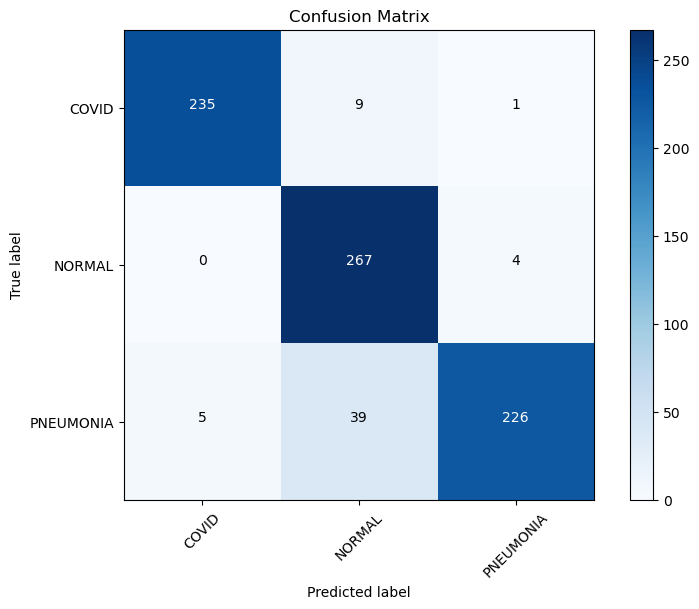

In [20]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = list(test_generator.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Classification Report

In [21]:
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.98      0.96      0.97       245
      NORMAL       0.85      0.99      0.91       271
   PNEUMONIA       0.98      0.84      0.90       270

    accuracy                           0.93       786
   macro avg       0.94      0.93      0.93       786
weighted avg       0.93      0.93      0.93       786



### visualize classification report

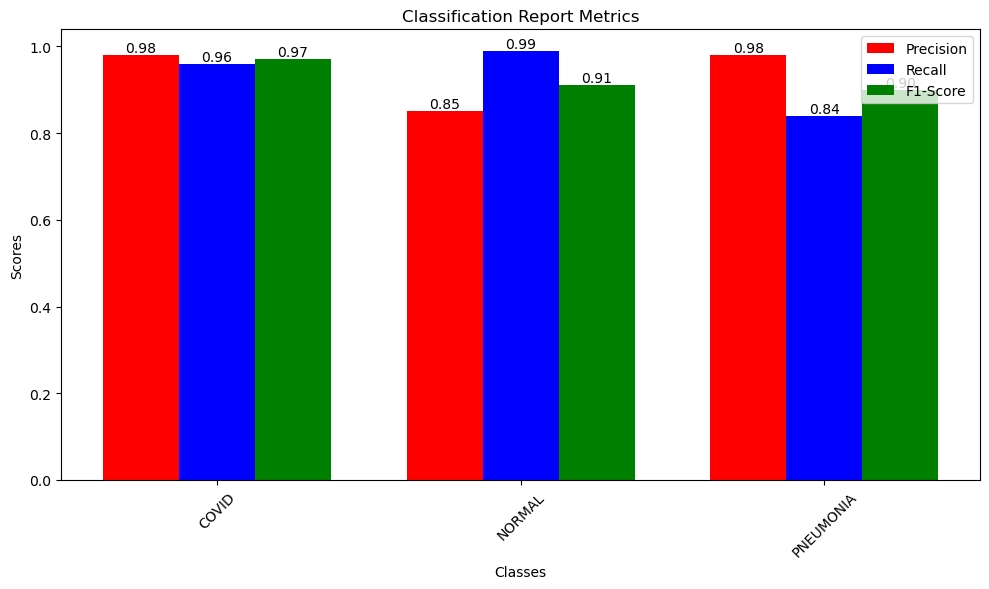

In [25]:
report_data = class_report.split('\n')
report_data = [data.split() for data in report_data if data]  # Split by spaces

classes = [data[0] for data in report_data[1:-3]]  # Extract classes
precision = [float(data[1]) for data in report_data[1:-3]]  # Extract precision values
recall = [float(data[2]) for data in report_data[1:-3]]  # Extract recall values
f1_score = [float(data[3]) for data in report_data[1:-3]]  # Extract F1-score values

plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(classes))

bars1 = plt.bar(index, precision, bar_width, color='r', label='Precision')
bars2 = plt.bar([i + bar_width for i in index], recall, bar_width, color='b', label='Recall')
bars3 = plt.bar([i + 2 * bar_width for i in index], f1_score, bar_width, color='g', label='F1-Score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks([i + bar_width for i in index], classes, rotation=45)
plt.legend()

# Add annotations
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 '%.2f' % height, ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()

### Plots results

In [23]:
#history = loaded_model.history
#print(history.history)

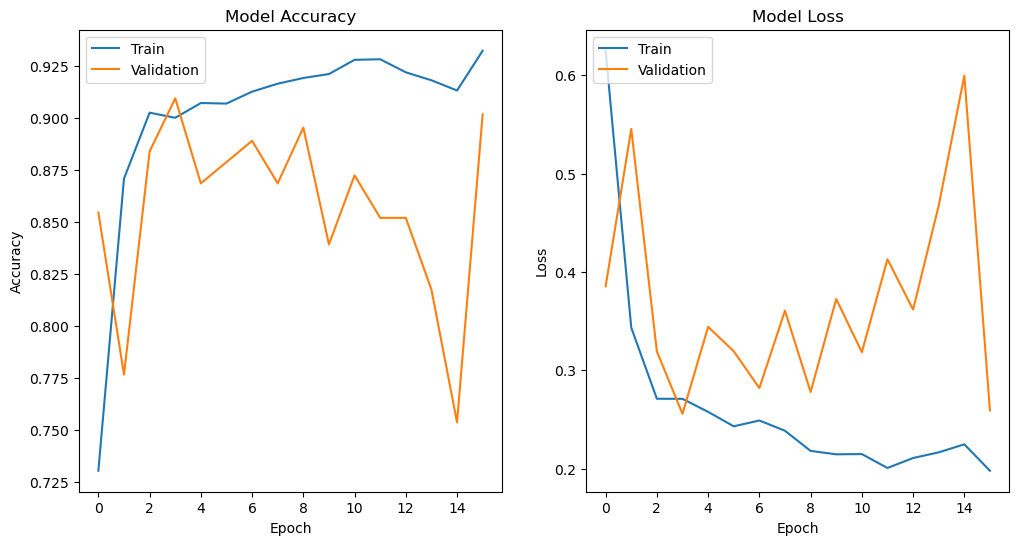

In [24]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()